# Analysing output from colab notebook

In [40]:
from sklearn import feature_selection, model_selection, metrics, linear_model
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
reference_df = pd.read_csv("EPCrisprBenchmark_ensemble_data_reference.tsv", sep="\t")
output_df = pd.read_csv("ENFORMER_output_0.tsv", sep="\t")
output_df = output_df.fillna(0)

df = reference_df.merge(output_df[["name", "ENFORMER_score"]], on = "name", how="left")
df["ENFORMER_score"] = df["ENFORMER_score"].fillna(0)

chrom_test_set = ["chr1", "chr11"]

# Naive Analysis

In [47]:
X_train = df[~df["chrom"].isin(chrom_test_set)][["ENFORMER_score"]]
y_train = df[~df["chrom"].isin(chrom_test_set)]["Regulated"]
X_test = df[df["chrom"].isin(chrom_test_set)][["ENFORMER_score"]]
y_test = df[df["chrom"].isin(chrom_test_set)]["Regulated"]

clf = linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9542805916629314


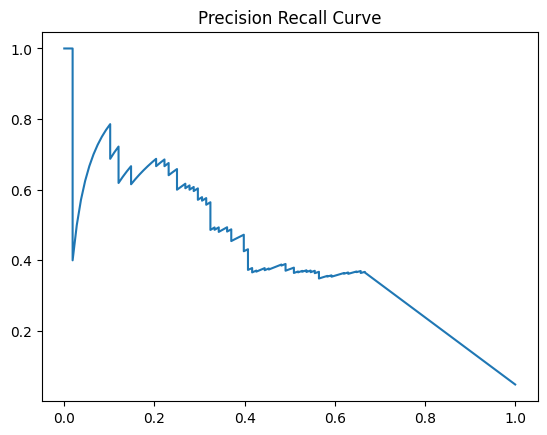

0.4190235294625503


In [48]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

print(aupr)

# The auprc is not shabby

In [39]:
feature_selection.mutual_info_classif(df["ENFORMER_score"].to_numpy().reshape(-1, 1), df["Regulated"])

# the Mutual Information is decent

array([0.05862762])

In [51]:
# Lets just gut check the logic that higher ENFORMER score contribution score means more likely to be genuine Enhancer regulating gene 
df[df["Regulated"]]["ENFORMER_score"].mean(), df[~df["Regulated"]]["ENFORMER_score"].mean()

(0.2179194700197721, 0.008357665811482567)

# Closer Analysis

In [54]:
(df["ENFORMER_score"]!=0).sum() / len(df)

0.10517721640572471

Only 10% of the candidate Enhancer Promoter Pairs are have distance to TSS within the ENFORMER output window. Which means for the other 90%, the model is blind and gives NaN (which we've filled in with 0).

Now that means distance becomes a confounding variable
- Because extremely far EPI candidates will get an automatic 0 for ENFORMER_score
- However since EPI depend on contact which decreases with distance, the % of genuine EPI decreases with distance
- So we need to be sure that the ENFORMER score has a predictive power beyond just naively assigning 0 to extremely far candidates

In [58]:
X_train = output_df[~output_df["chrom"].isin(chrom_test_set)][["ENFORMER_score"]]
y_train = output_df[~output_df["chrom"].isin(chrom_test_set)]["Regulated"]
X_test = output_df[output_df["chrom"].isin(chrom_test_set)][["ENFORMER_score"]]
y_test = output_df[output_df["chrom"].isin(chrom_test_set)]["Regulated"]

clf = linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

print("aupr", aupr)
print("MI", feature_selection.mutual_info_classif(output_df["ENFORMER_score"].to_numpy().reshape(-1, 1), output_df["Regulated"]))
print("ENFORMER contribution score (regulated, ~regulated)")
print(output_df[output_df["Regulated"]]["ENFORMER_score"].mean(), output_df[~output_df["Regulated"]]["ENFORMER_score"].mean())


0.6751269035532995
aupr 0.5250625394936728
MI [0.0793227]
ENFORMER contribution score (regulated, ~regulated)
0.3121375938224383 0.10985625895781856


So it turns out that within the 10% of EPI that the ENFORMER can rule on, it performs even better.
Which means the ENFORMER score is an extremely effective feature, provided the EPI candidates are within 114kbp. 